# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding** 


## Import Packages

In [6]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

## Compute the camera calibration matrix and distortion coefficients 

We use chess board images to perform the camera calibration. The corresponding algorithm is as follows...

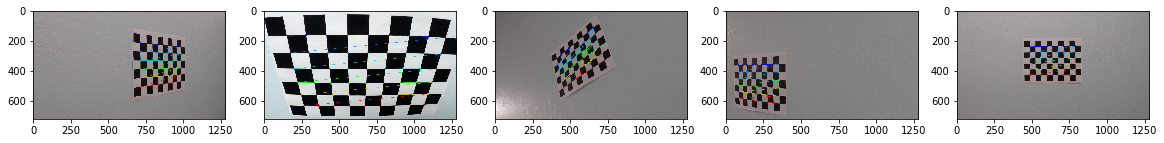

In [24]:
# Enter number of chess board inside corners
nx = 9 # Inside corners in x-axis
ny = 6 # Inside corners in y-axis
# Prepare the object points, like (0,0,0), (1,0,0), (2,0,0), ..., (8,5,0) 
objp = np.zeros((ny*nx,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
# Initialize arrays to store object points and image points from all the images
objpoints = []
imgpoints = []
# Take in calibration images
images = glob.glob('camera_cal/calibration*.jpg')
fig, axs = plt.subplots(1,5, figsize=(20, 5))
axs = axs.ravel()
for i, fname in enumerate(images):    
    #color image
    image = cv2.imread(fname)
    # Convert the BGR format color image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #Find the number of corners in the chessboard
    ret, corners = cv2.findChessboardCorners(gray,(nx,ny), None)
    # If corners are found, then draw chess board corners
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw chess board corners
        img = cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
        if i in range(5):
            axs[i].imshow(img)

Text(0.5,1,'Undistorted Image')

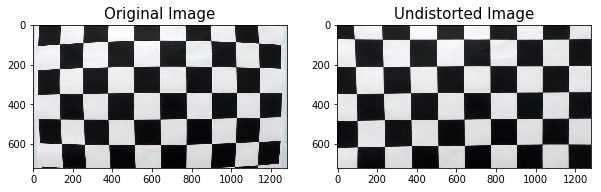

In [8]:
# Calibrate the camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
# undistort
original_image = cv2.imread('camera_cal/calibration1.jpg')
undistorted_image = cv2.undistort(original_image, mtx, dist, None, mtx)
# Visulaizaiton plots
f, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.imshow(original_image)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=15)

## Read all the test images

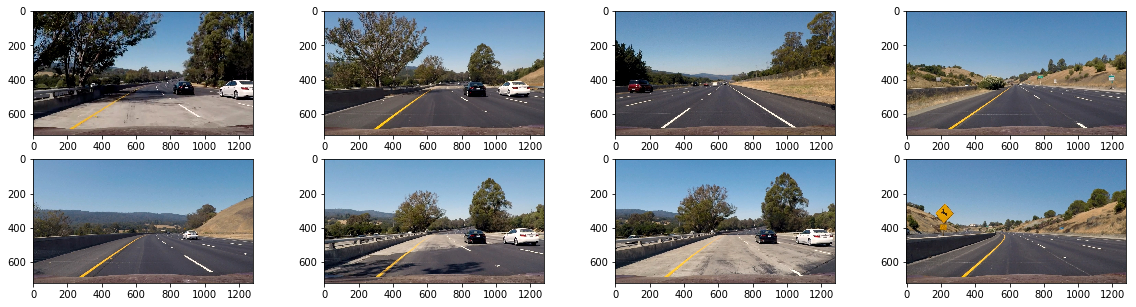

In [9]:
fig, axs = plt.subplots(2,4, figsize=(20, 5))
axs = axs.ravel()
images = glob.glob('test_images/*.jpg')
for i, filename in enumerate(images): 
    color_img = mpimg.imread(filename)
    axs[i].imshow(color_img) 

## Undistort the images

Text(0.5,1,'Undistorted Image')

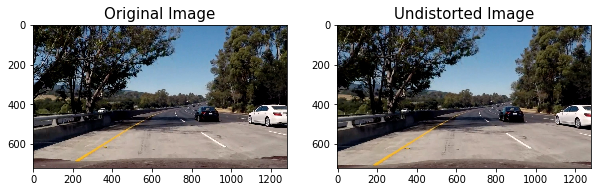

In [10]:
def undistort_image(orig_image):
    undist_img = cv2.undistort(orig_image, mtx, dist, None, mtx)
    return undist_img

orig_image = mpimg.imread('test_images/test5.jpg')
undist_img = undistort_image(orig_image)
# Visualization
f, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.imshow(orig_image)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=15)

## Color thresholding

Text(0.5,1,'Combined thresholds')

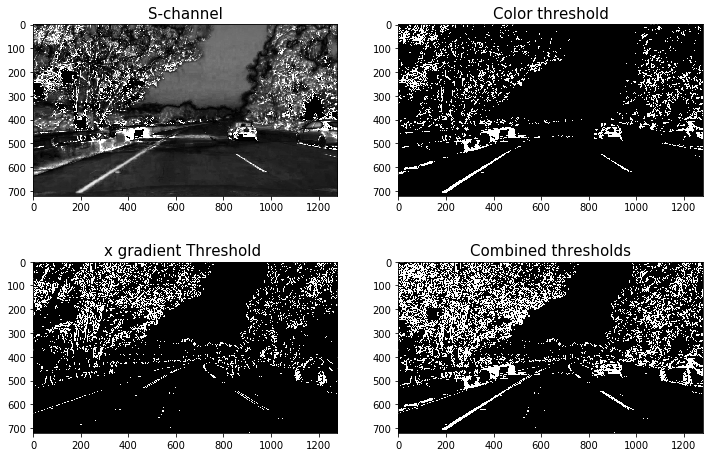

In [25]:
def color_thresholding(image):   
    #Convert to HLS 
    hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # sobel x
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivitive in x
    abs_sobel_x = np.absolute(sobel_x) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobel_x/np.max(abs_sobel_x))

    #Threshold x-gradient
    thres_min = 20
    thres_max = 160 
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel>=thres_min) & (scaled_sobel<=thres_max)]=1

    # Applying color threshold
    thres_max = 255
    thres_min = 150
    binary = np.zeros_like(S)
    binary[(S > thres_min) & (S <= thres_max)] = 1

    #combined the two binary threshold images
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(binary ==1) | (sx_binary==1)] = 1
    edges = combined_binary
    return edges,S,binary,sx_binary

edges,S,binary,sx_binary = color_thresholding(undist_img)
#Visulaization
f,((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(12,8))
ax1.imshow(S, cmap='gray')
ax1.set_title('S-channel', fontsize=15)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Color threshold', fontsize=15)
ax3.imshow(sx_binary, cmap='gray')
ax3.set_title('x gradient Threshold ', fontsize=15)
ax4.imshow(edges, cmap='gray')
ax4.set_title('Combined thresholds', fontsize=15)


## Region of interest

Text(0.5,1,'Masked image')

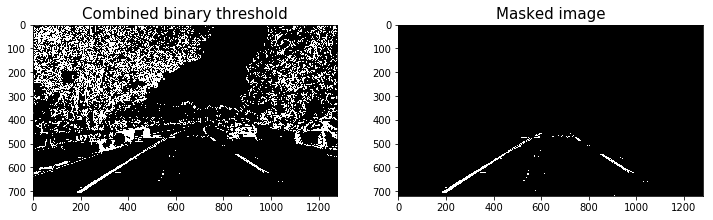

In [26]:
def region_of_interest(img, vertices):
    """
    Applies an image mask. Only keeps the region of the image defined by the polygon formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)       
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

height = image.shape[0]
width = image.shape[1]
midpoint = image.shape[1]/2
left_bottom = [0,height]
right_bottom = [width-0,height]
left_apex = [midpoint-80,(height+190)/2]
right_apex = [midpoint+80,(height+190)/2]
# Vertices of a trapezium 
vertices = np.array([[left_bottom,left_apex,right_apex,right_bottom]], dtype=np.int32)
# Region of Interest
masked_image = region_of_interest(edges, vertices)

#Visulaization
f,(ax1, ax2) = plt.subplots(1,2,figsize=(12,8))
ax1.imshow(edges, cmap='gray')
ax1.set_title('Combined binary threshold', fontsize=15)
ax2.imshow(masked_image, cmap='gray')
ax2.set_title('Masked image', fontsize=15)

## Perspective Transformation

Text(0.5,1,'Warped image')

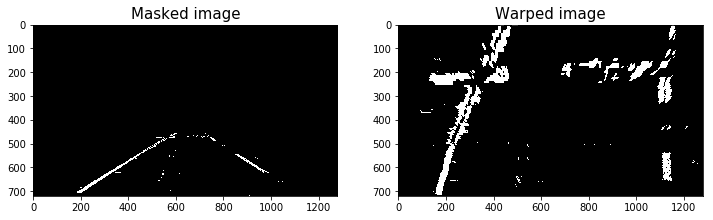

In [30]:
# Choose source and destination
def perspective_transform(image,src,dst):
    # Perspective transformation
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(image, M, (image.shape[1],image.shape[0]), flags=cv2.INTER_LINEAR)
    return warped, Minv

#edges,S,binary,sx_binary = color_thresholding(image)
src = np.float32([[200,height],left_apex,right_apex,[1150,height]])
dst = np.float32([[200,height],[200,0],[1150,0],[1150,height]])
warped, Minv = perspective_transform(masked_image,src,dst)

#Visulaization
f,(ax1, ax2) = plt.subplots(1,2,figsize=(12,8))
ax1.imshow(masked_image, cmap='gray')
ax1.set_title('Masked image', fontsize=15)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped image', fontsize=15)   

## Fit polynomials to left and right lane markings

Text(0.5,1,'Polynomial fit')

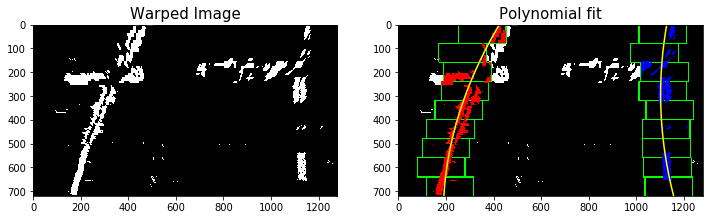

In [28]:
def find_lane_pixels(warped):
    # #identify the x and y positions of all nonzero (i.e activated) pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img = np.dstack((warped, warped, warped))*255
    
    # Plot windows on the image
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    mid_hist =  np.int(histogram.shape[0]/2)
    quarter_point = np.int(mid_hist//2)
    left_peak = np.argmax(histogram[:mid_hist])
    right_peak = np.argmax(histogram[mid_hist:])+mid_hist
    #hyperparameters
    nwindows = 9
    win_width = 100
    min_pix = 50 # minimum number of pixcels found to recenter window
    win_height = np.int(warped.shape[0]/nwindows)
    # Current positions to be updated later for each window in nwindows
    leftx_current = left_peak
    rightx_current = right_peak    
    left_lane = []
    right_lane = []
    # loop through all windows
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*win_height
        win_y_high = warped.shape[0] - window*win_height
        win_xleft_low = leftx_current - win_width
        win_xleft_high = leftx_current + win_width
        win_xright_low = rightx_current - win_width
        win_xright_high = rightx_current + win_width       
        # Create an output image to draw on and visualize the result
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Grab only the pixels within the window
        good_left_pixels = ((win_xleft_high > nonzerox) & (nonzerox >= win_xleft_low) & (win_y_high > nonzeroy) & (nonzeroy >= win_y_low)).nonzero()[0]
        good_right_pixels =((win_xright_high > nonzerox) & (nonzerox >= win_xright_low) & (win_y_high > nonzeroy) & (nonzeroy >= win_y_low)).nonzero()[0]
        # Append these indices to the lists
        left_lane.append(good_left_pixels)
        right_lane.append(good_right_pixels)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_pixels) > min_pix:
            leftx_current = np.int(np.mean(nonzerox[good_left_pixels]))
        if len(good_right_pixels) > min_pix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_pixels]))

    # concatinate the arrays of indices previously was a list of lists of pixels)  
    left_lane = np.concatenate(left_lane)
    right_lane = np.concatenate(right_lane)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane]
    lefty = nonzeroy[left_lane] 
    rightx = nonzerox[right_lane]
    righty = nonzeroy[right_lane]    
    return leftx,lefty,rightx,righty,out_img    
  
def fit_polynomial(image):   
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(image)
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]    
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    ploty = np.linspace(0,warped.shape[0]-1,warped.shape[0])    
    #left_radius, right_radius = radius_of_curvature(left_fit_real,right_fit_real,ploty)    
    left_fit_x = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit_x = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    margin = 80
    left_line_window1 = np.array([np.transpose(np.vstack([left_fit_x-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fit_x+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fit_x-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fit_x+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    window_img = np.zeros_like(out_img)
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    return out_img,left_fit_x,right_fit_x,left_fit,right_fit,lefty,leftx,righty,rightx

out_img,left_fit_x,right_fit_x,left_fit,right_fit,lefty,leftx,righty,rightx = fit_polynomial(warped)
#Visulaization
f,(ax1, ax2) = plt.subplots(1,2,figsize=(12,8))
ploty = np.linspace(0,warped.shape[0]-1,warped.shape[0])
ax1.imshow(warped, cmap='gray')
ax1.set_title('Warped Image', fontsize=15)
ax2.imshow(out_img, cmap='gray')
ax2.plot(left_fit_x, ploty, color='yellow')
ax2.plot(right_fit_x, ploty, color='yellow')
ax2.set_title('Polynomial fit', fontsize=15) 

## Warp the detected lane boundaries back onto the original image

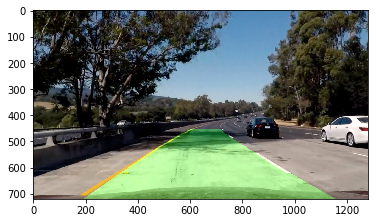

In [15]:
def drawLine(img, left_fit_x, right_fit_x, Minv):
    """
    Draw the lane lines on the undistorted image using the poly `left_fit_x` and `right_fit_x`.
    """
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fit_x, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit_x, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

Warp_image = drawLine(undist_img, left_fit_x, right_fit_x,Minv)
plt.imshow(Warp_image)

## Determine the curvature of the lane and vehicle position with respect to center

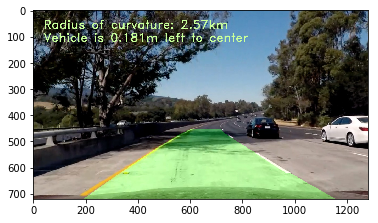

In [16]:
def draw_data(image, curv_rad, center_dist):
    copy_img = np.copy(image)
    h = copy_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Radius of curvature: ' + '{:04.2f}'.format(curv_rad) + 'km'
    cv2.putText(copy_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = 'Vehicle is '+'{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' to center'
    cv2.putText(copy_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return copy_img

def radius_of_curvature(image,left_fit,right_fit,lefty,leftx,righty,rightx,ploty,xm_per_pix,ym_per_pix):
    # choose maximum y-value corresponding to the bottom of the image
    left_fit_real = np.polyfit(lefty*ym_per_pix,leftx*xm_per_pix,2)
    right_fit_real = np.polyfit(righty*ym_per_pix,rightx*xm_per_pix,2)
    
    y_eval = np.max(ploty)
    left_radius = ((1+(2*left_fit_real[0]*y_eval+left_fit_real[1])**2)**(3/2))/np.absolute(2*left_fit_real[0])/1000
    right_radius = ((1+(2*right_fit_real[0]*y_eval+right_fit_real[1])**2)**(3/2))/np.absolute(2*right_fit_real[0])/1000
    
    car_position = image.shape[1]/2
    left_lane = left_fit[0]*image.shape[0]**2 + left_fit[1]*image.shape[0] + left_fit[2]
    right_lane = right_fit[0]*image.shape[0]**2 + right_fit[1]*image.shape[0] + right_fit[2]
    lane_center = (left_lane + right_lane) /2
   
    center_dist = (car_position - lane_center) * xm_per_pix
    return left_radius, right_radius, center_dist  

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
left_radius, right_radius, center_dist = radius_of_curvature(undist_img,left_fit,right_fit,lefty,leftx,righty,rightx,ploty,xm_per_pix,ym_per_pix)
copy_img = draw_data(Warp_image, (left_radius+right_radius)/2, center_dist)
plt.imshow(copy_img)

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [18]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # Read in and grayscale the image
    # convert the image to grayscale image
    height = image.shape[0]
    width = image.shape[1]
    midpoint = image.shape[1]/2
    left_bottom = [0,height]
    right_bottom = [width-0,height]
    left_apex = [midpoint-70,(height+185)/2]
    right_apex = [midpoint+70,(height+185)/2]
    
    image = cv2.undistort(image, mtx, dist, None, mtx)
    edges,S,binary,sx_binary = color_thresholding(image)    
    
    # Vertices of a trapezium 
    vertices = np.array([[left_bottom,left_apex,right_apex,right_bottom]], dtype=np.int32)
    # Region of Interest
    masked_image = region_of_interest(edges, vertices)
    
    src = np.float32([[200,height],left_apex,right_apex,[1150,height]])
    dst = np.float32([[200,height],[200,0],[1150,0],[1150,height]])
    warped, Minv = perspective_transform(masked_image,src,dst)
    out_img,left_fit_x,right_fit_x,left_fit,right_fit,lefty,leftx,righty,rightx = fit_polynomial(warped)
    img = drawLine(image, left_fit_x, right_fit_x, Minv)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_radius, right_radius, center_dist = radius_of_curvature(img,left_fit,right_fit,lefty,leftx,righty,rightx,ploty,xm_per_pix,ym_per_pix)
    output = draw_data(img, (left_radius+right_radius)/2, center_dist)
    return output

Let's try the one with the solid white lane on the right first ...

In [31]:
import os
# Create the target directory to save the outputs
OutdirName = 'test_videos_output'
if not os.path.exists(OutdirName):
    os.mkdir(OutdirName)
    print("Directory ", OutdirName, "has been created ")
    
white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [04:16<00:00,  5.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 2min 7s, sys: 10.6 s, total: 2min 17s
Wall time: 4min 19s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))